In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 99% 193M/195M [00:05<00:00, 39.4MB/s]
100% 195M/195M [00:05<00:00, 35.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('movielens-20m-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Import and Preparing Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('rating.csv')

In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
df.drop('timestamp', axis=1, inplace=True)

In [ ]:
df.nunique()

userId     138493
movieId     26744
rating         10
dtype: int64

In [ ]:
df['rating'].value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

In [ ]:
df.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [ ]:
#Chaning the movie and user indexes so that they all start from 0 and maintain uniformity

In [ ]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
df['userId'] = user_le.fit_transform(df['userId'])

movie_le = LabelEncoder()
df['movieId'] = movie_le.fit_transform(df['movieId'])

In [ ]:
df.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904487e+04,3.602899e+03,3.525529e+00
std,4.003863e+04,4.136939e+03,1.051989e+00
min,0.000000e+00,0.000000e+00,5.000000e-01
25%,3.439400e+04,8.850000e+02,3.000000e+00
50%,6.914000e+04,2.083000e+03,3.500000e+00
75%,1.036360e+05,4.674000e+03,4.000000e+00
max,1.384920e+05,2.674300e+04,5.000000e+00


# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop('rating', axis=1)
y = df['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [22]:
X_train.shape

(16000210, 2)

In [23]:
X_val.shape

(4000053, 2)

# Model Building

In [64]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input,Dense,Dropout,Embedding,Flatten,BatchNormalization,Input,concatenate,Add
from keras.regularizers import l2

In [65]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()
k = 80
l2_lambda = 0.001

In [66]:
u_input = Input((1,), name='user_input')
u = Embedding(num_users, k, name='user_emb')(u_input)
u = Flatten(name='user_flat')(u)
u = Dense(48, activation='relu', name='user_dense')(u)

In [67]:
m_input = Input((1,), name='movie_input')
m = Embedding(num_movies, k, name='movie_emb')(m_input)
m = Flatten(name='movie_flat')(m)
m = Dense(48, activation='relu', name='movie_dense')(m)

In [68]:
x = concatenate([u, m], name='concat')
x = Dropout(0.1, name='drop1')(x)
x = Dense(64, activation='relu', name='dense1')(x)
x = Dense(16, activation='relu', name='dense2')(x)
o = Dense(1, name='output')(x)

In [69]:
u_bias = Embedding(num_users, 1, embeddings_regularizer=l2(l2_lambda), name='user_bias_emb')(u_input)
u_bias = Flatten(name='user_bias_flat')(u_bias)
u_bias = Dense(1, activation='relu', name='user_bias_dense')(u_bias)

m_bias = Embedding(num_movies, 1, embeddings_regularizer=l2(l2_lambda), name='movie_bias_emb')(m_input)
m_bias = Flatten(name='movie_bias_flat')(m_bias)
m_bias = Dense(1, activation='relu', name='movie_bias_dense')(m_bias)
m_bias = Dropout(0.2, name='movie_bias_drop')(m_bias)

o = Add()([o, u_bias, m_bias])

In [70]:
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError

model = Model(inputs=[u_input, m_input], outputs=o)

metrics = [
    MeanSquaredError(name='mse'),
    MeanAbsoluteError(name='mae'),
    RootMeanSquaredError(name='rmse')
]

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.001), loss='mean_squared_error', metrics = metrics)

In [71]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_emb (Embedding)        (None, 1, 80)                1107944   ['user_input[0][0]']          
                                                          0                                       
                                                                                                  
 movie_emb (Embedding)       (None, 1, 80)                2139520   ['movie_input[0][0]']   

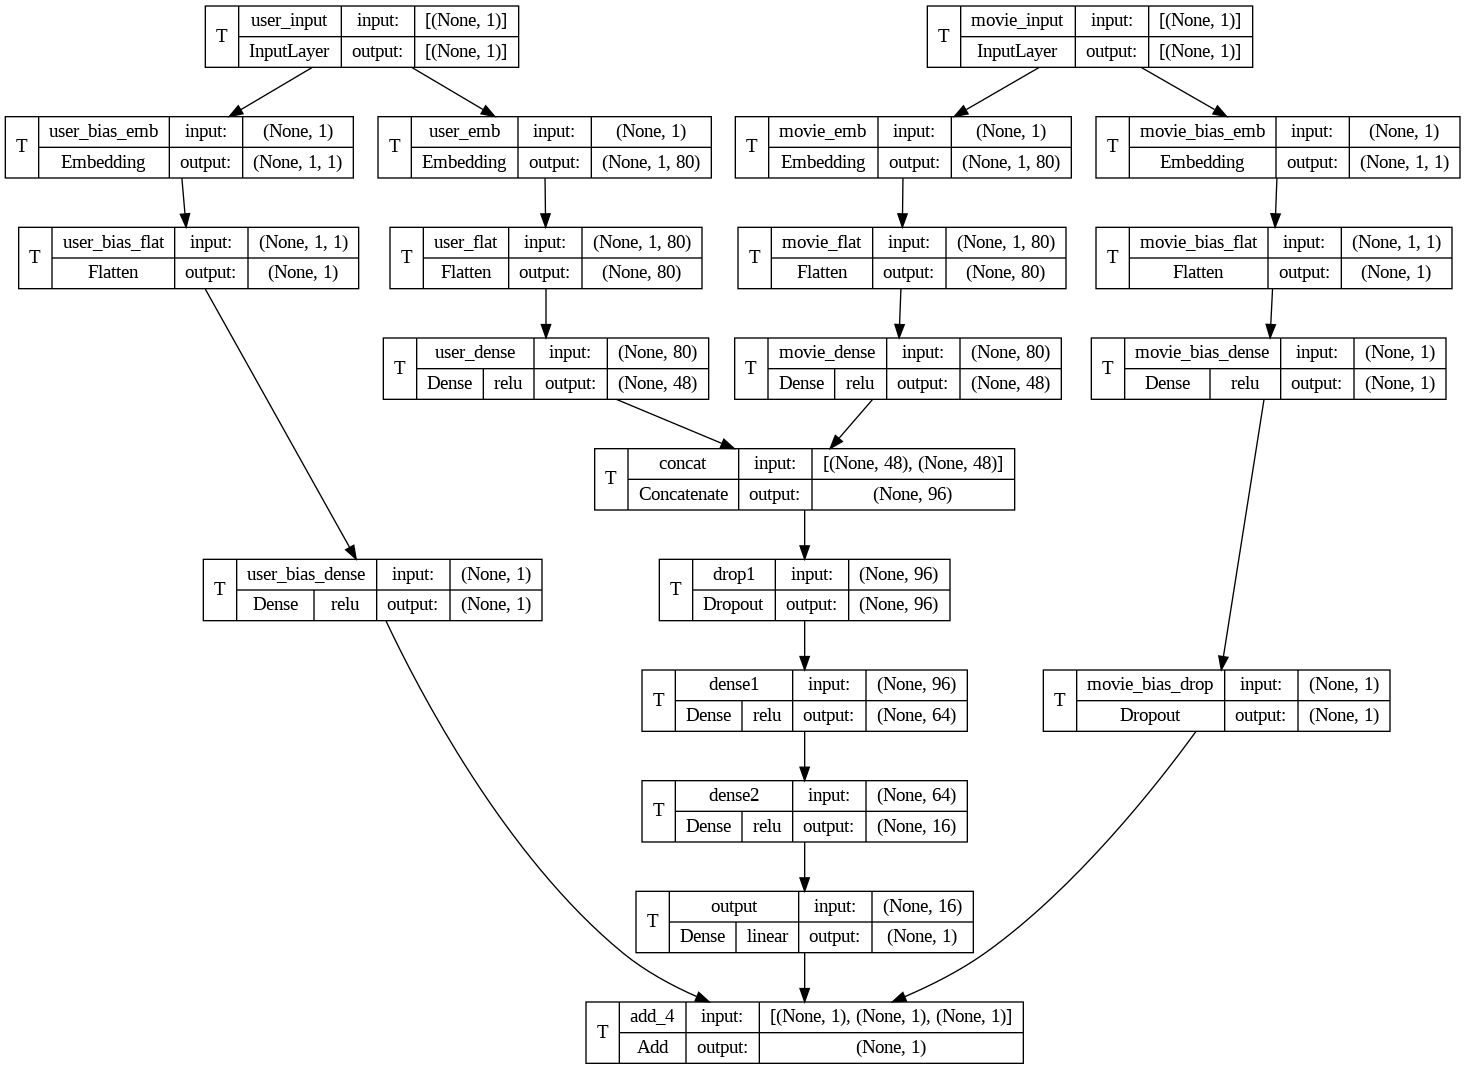

In [72]:
from keras.utils import plot_model

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
    show_trainable=True,
)

In [73]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.1,
    patience=3,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True
)

In [74]:
import os

path_checkpoint = "model_cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)

model_weights_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoint,
    save_weights_only=True,
    verbose=1
  )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5',monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(
    x=[X_train['userId'], X_train['movieId']],
    y=y_train, batch_size=64 ,epochs=5,
    validation_data=([X_val['userId'], X_val['movieId']], y_val),
    callbacks=[early_stopping, model_checkpoint, model_weights_checkpoint]
)

Epoch 1/5
250002/250004 [============================>.] - ETA: 0s - loss: 0.7445 - mse: 0.7438 - mae: 0.6600 - rmse: 0.8624
Epoch 1: val_loss improved from inf to 0.69974, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: saving model to model_cp.ckpt
250004/250004 [==============================] - 3012s 12ms/step - loss: 0.7445 - mse: 0.7438 - mae: 0.6600 - rmse: 0.8624 - val_loss: 0.6997 - val_mse: 0.6996 - val_mae: 0.6385 - val_rmse: 0.8364
Epoch 2/5
169454/250004 [===================>..........] - ETA: 15:32 - loss: 0.6886 - mse: 0.6884 - mae: 0.6316 - rmse: 0.8297

# Saving the model

In [ ]:
from joblib import dump

tf.keras.models.save_model('model.h5', model)

dump(user_le, 'user_le.joblib')
dump(movie_le, 'movie_le.joblib')

['movie_le.joblib']